In [1]:
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from attention import AttentionLayer

2024-04-12 08:58:27.989562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 08:58:27.989597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 08:58:27.990585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 08:58:27.996544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 08:58:28.738317: W tensorflow/compiler/tf2

In [2]:
data = pd.read_csv("./review_data.csv")

In [3]:
data.head()

,Processed_Text,Processed_Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [4]:
data.isna().sum()

Processed_Text         3
Processed_Summary    351
dtype: int64

In [5]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)

In [6]:
data.isna().sum()

Processed_Text       0
Processed_Summary    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 1919
텍스트의 평균 길이 : 38.02495886390629
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 3.959993082523963


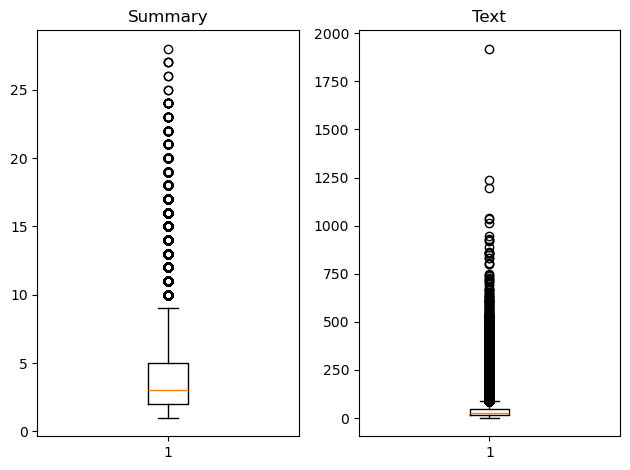

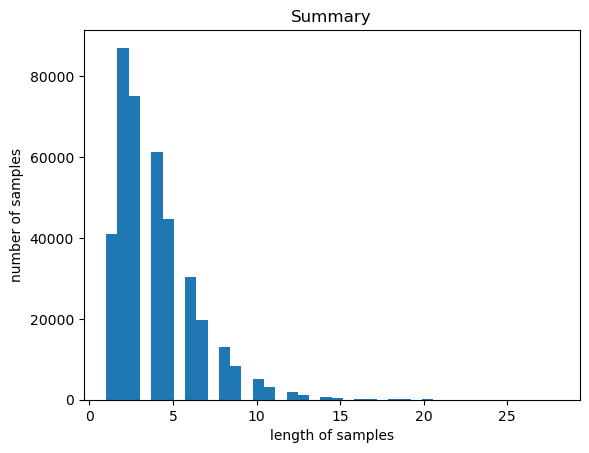

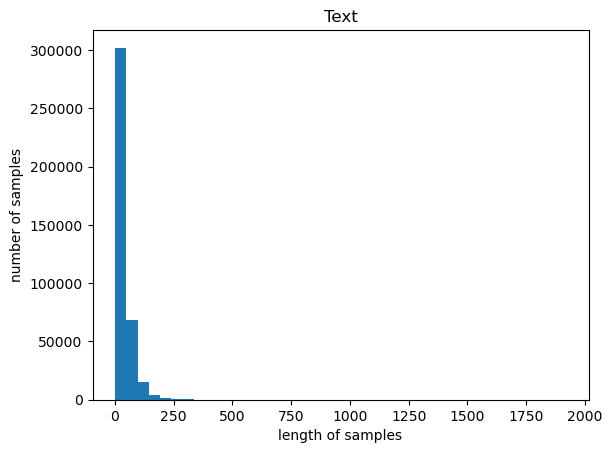

In [7]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Processed_Text']]
summary_len = [len(s.split()) for s in data['Processed_Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
len(data)

393207

In [9]:
text_max_len = 50
summary_max_len = 8

In [10]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [11]:
below_threshold_len(text_max_len, data['Processed_Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7832134219380632


In [12]:
below_threshold_len(summary_max_len, data['Processed_Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9458147998382531


In [13]:
data = data[data['Processed_Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Processed_Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 296579


In [14]:
# seq2seq 학습을 위해 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['Processed_Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Processed_Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Processed_Text,Processed_Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [15]:
# 인코더와 디코더의 입력과 레이블을 각각 설정한다.
encoder_input = np.array(data['Processed_Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [16]:
# # 데이터를 랜덤하게 분리하기 위해 정수 시퀀스를 생성
# indices = np.arange(encoder_input.shape[0])
# np.random.shuffle(indices)

In [17]:
# encoder_input = encoder_input[indices]
# decoder_input = decoder_input[indices]
# decoder_target = decoder_target[indices]

In [18]:
test_num = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',test_num)

테스트 데이터의 수 : 59315


In [19]:
len(encoder_input)

296579

In [20]:
encoder_input_train = encoder_input[:-test_num]
decoder_input_train = decoder_input[:-test_num]
decoder_target_train = decoder_target[:-test_num]

encoder_input_test = encoder_input[-test_num:]
decoder_input_test = decoder_input[-test_num:]
decoder_target_test = decoder_target[-test_num:]

In [21]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 237264
훈련 레이블의 개수 : 237264
테스트 데이터의 개수 : 59315
테스트 레이블의 개수 : 59315


In [22]:
# 모델이 더 잘 학습할 수 있도록 정수 인코딩
# 훈련 데이터에 대해 단어 집합을 생성
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [23]:
src_tokenizer.word_index

{'like': 1,
 'good': 2,
 'great': 3,
 'taste': 4,
 'product': 5,
 'love': 6,
 'one': 7,
 'coffee': 8,
 'flavor': 9,
 'would': 10,
 'tea': 11,
 'really': 12,
 'get': 13,
 'amazon': 14,
 'best': 15,
 'price': 16,
 'buy': 17,
 'use': 18,
 'much': 19,
 'find': 20,
 'time': 21,
 'little': 22,
 'tried': 23,
 'food': 24,
 'better': 25,
 'make': 26,
 'also': 27,
 'well': 28,
 'try': 29,
 'chocolate': 30,
 'even': 31,
 'eat': 32,
 'bought': 33,
 'delicious': 34,
 'found': 35,
 'order': 36,
 'used': 37,
 'sweet': 38,
 'could': 39,
 'tastes': 40,
 'sugar': 41,
 'free': 42,
 'cannot': 43,
 'recommend': 44,
 'store': 45,
 'first': 46,
 'drink': 47,
 'dog': 48,
 'nice': 49,
 'box': 50,
 'cup': 51,
 'favorite': 52,
 'made': 53,
 'way': 54,
 'bag': 55,
 'loves': 56,
 'go': 57,
 'mix': 58,
 'got': 59,
 'ordered': 60,
 'water': 61,
 'perfect': 62,
 'think': 63,
 'since': 64,
 'ever': 65,
 'day': 66,
 'easy': 67,
 'stuff': 68,
 'hot': 69,
 'makes': 70,
 'many': 71,
 'bit': 72,
 'two': 73,
 'still': 74,
 

In [24]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 70082
등장 빈도가 6번 이하인 희귀 단어의 수: 53061
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17021
단어 집합에서 희귀 단어의 비율: 75.71273650866128
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5963623701138094


In [25]:
# 희귀단어를 제외하고 단어 집합의 크기를 170000으로 제한
src_vocab = 17000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [26]:
print(encoder_input_train[:3])

[[33, 199, 6643, 536, 48, 24, 113, 35, 2, 81, 5, 514, 1, 2451, 1199, 403, 452, 25, 4985, 1837, 6170, 5, 25], [5, 147, 2230, 3940, 1542, 795, 795, 181, 122, 991, 3083, 123, 2746, 997, 2572, 7034, 5, 3940], [6388, 200, 12499, 222, 1704, 2709, 339, 238, 13604, 469, 757, 2236, 7327, 2283, 1151, 41, 757, 5623, 1345, 443, 366, 111, 44, 296, 138, 2295, 2786, 6720, 9685, 138, 865, 1656, 5124, 9685]]


In [27]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [28]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 23416
등장 빈도가 5번 이하인 희귀 단어의 수: 17656
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 5760
단어 집합에서 희귀 단어의 비율: 75.40143491629655
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.8110310728770194


In [29]:
tar_vocab = 5000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [31]:
print(decoder_input_train[:3])

[[1, 4, 64, 33, 37], [1, 7, 39, 420], [1, 458, 519, 11, 78]]


In [32]:
print(decoder_target_train[:3])

[[4, 64, 33, 37, 2], [7, 39, 420, 2], [458, 519, 11, 78, 2]]


In [33]:
# 길이가 0인 샘플들은 지워줍니다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [34]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 3308
삭제할 테스트 데이터의 개수 : 908


In [35]:
encoder_input_train = np.array(encoder_input_train, dtype=object)
decoder_input_train = np.array(decoder_input_train , dtype=object)
decoder_target_train = np.array(decoder_target_train, dtype=object)

encoder_input_test = np.array(encoder_input_test, dtype=object)
decoder_input_test = np.array(decoder_input_test, dtype=object)
decoder_target_test = np.array(decoder_target_test, dtype=object)

In [36]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

In [37]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 233956
훈련 레이블의 개수 : 233956
테스트 데이터의 개수 : 58407
테스트 레이블의 개수 : 58407


In [38]:
# 데이터 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [39]:
# 인코딩 설계
# LSTM 층을 3개 쌓습니다.
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

2024-04-12 08:58:56.888060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 08:58:56.924809: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 08:58:56.924955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-04-12 08:58:58.385697: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [40]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [41]:
# # 디코더의 출력층
# decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [42]:
# # 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()

In [43]:
# 어텐션 레이어를 사용한 디코더 출력층

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              2176000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
with tf.device("/device:GPU:0"): 
    history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50


2024-04-12 08:59:08.643934: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbb681035a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 08:59:08.643963: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 08:59:08.648552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 08:59:09.004555: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1712912349.041758 3924048 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


914/914 [==============================] - 368s 391ms/step - loss: 2.8129 - val_loss: 2.5685
Epoch 2/50
914/914 [==============================] - 345s 377ms/step - loss: 2.5335 - val_loss: 2.4418
Epoch 3/50
914/914 [==============================] - 344s 376ms/step - loss: 2.4104 - val_loss: 2.3283
Epoch 4/50
914/914 [==============================] - 344s 376ms/step - loss: 2.3129 - val_loss: 2.2522
Epoch 5/50
914/914 [==============================] - 344s 377ms/step - loss: 2.2385 - val_loss: 2.1865
Epoch 6/50
914/914 [==============================] - 342s 374ms/step - loss: 2.1783 - val_loss: 2.1444
Epoch 7/50
914/914 [==============================] - 348s 381ms/step - loss: 2.1292 - val_loss: 2.0988
Epoch 8/50
914/914 [==============================] - 345s 377ms/step - loss: 2.0814 - val_loss: 2.0614
Epoch 9/50
914/914 [==============================] - 340s 372ms/step - loss: 2.0417 - val_loss: 2.0317
Epoch 10/50
914/914 [==============================] - 345s 377ms/step - lo

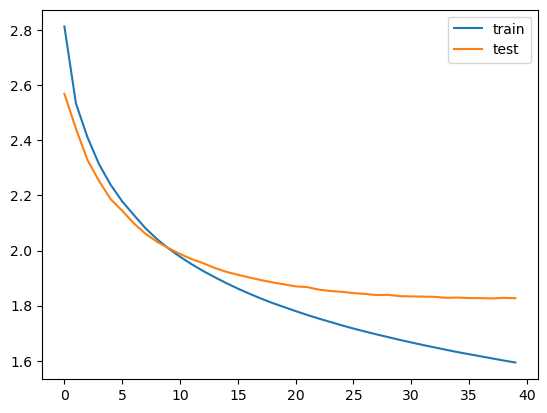

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
# test를 위해 3개의 사전을 생성
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [48]:
# 테스트 단계를 위한 모델 설계
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
# 테스트를 위해 사용하는 합수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [51]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  says yes place good price cats love definitely purchasing 
실제 요약문 : make your kitties happy 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  cats love it


원문 :  wanted save buying bulk subscription service deal cans came dented savings receiving rather pick individual cans variety cats anyways 
실제 요약문 : too many dented cans 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  good price


원문 :  cats like friskies fillets continue buying product change appetite far still looking towards think fact bits either meat hard things chew like 
실제 요약문 : my cats say yes 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  my cats love this


원문 :  cats eating friskies lives always get good health reviews annual visits vet 
실제 요약문 : kitty fav 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  cats love it


원문 :  affordable easy get cases every months lifting shelf cart cart register register cart car car stairs open front door waiting packaged

In [52]:
# result=data[['Processed_Text','Processed_Summary']]

In [53]:
len(encoder_input_test)

58407

In [56]:
1+1

2

In [ ]:
# for i in range(100, 200):
#     print("원문 : ",seq2text(encoder_input_test[i]))
#     print("실제 요약문 :",seq2summary(decoder_input_test[i]))
#     print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
#     print("\n")

In [57]:
result=[]

In [58]:
for i in range(0, 10000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    res_sentence=decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    print("예측 요약문 :",res_sentence)
    result.append(res_sentence)
    print("\n")

원문 :  buy gummy bears running toilet could figure stomach issues gas family started problems went read amazon reviews confirmed taste great pay sure amazon still shelf bad reviews 
실제 요약문 : major stomach upset do not buy 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  great product but


원문 :  far product concerned greatest taste well worth money however reason low rating buy sugar free bears pound bag lot product person eat trying watch calories hard bag great haribo gummy bears eating flavor great regular bears 
실제 요약문 : the best gummy bears ever 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  delicious


원문 :  eat time never upset stomach gas wish little softer still type diabetic great snack 
실제 요약문 : great 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great for


원문 :  taste good sugar ones best part gives tons gas really fun around friends make sure eat job something 
실제 요약문 : tastes great makes you 
1/1 [============================

In [59]:
len(result)

10000

In [60]:
input_text=[]
input_summ=[]

In [61]:
for i in range(0, 10000):
    cur_text=seq2text(encoder_input_test[i])
    cur_summ=seq2summary(decoder_input_test[i])
    input_text.append(cur_text)
    input_summ.append(cur_summ)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [62]:
input_text

['buy gummy bears running toilet could figure stomach issues gas family started problems went read amazon reviews confirmed taste great pay sure amazon still shelf bad reviews ',
 'far product concerned greatest taste well worth money however reason low rating buy sugar free bears pound bag lot product person eat trying watch calories hard bag great haribo gummy bears eating flavor great regular bears ',
 'eat time never upset stomach gas wish little softer still type diabetic great snack ',
 'taste good sugar ones best part gives tons gas really fun around friends make sure eat job something ',
 'delicious ate couple hours later started feel really sick spent whole rest day suffering painful gastrointestinal distress believe occasional side effect sugar substitute problem go right ahead munch away know would try small quantities first make sure cause problems ',
 'one reviewer mentioned low carbs almost carbs sugar alcohol absorbed body perfectly good low carb diet limit intake time '

In [63]:
res_df=pd.DataFrame({'text':input_text,'summary':input_summ,'Res':result})

In [64]:
res_df.head()

,text,summary,Res
0,buy gummy bears running toilet could figure st...,major stomach upset do not buy,great product but
1,far product concerned greatest taste well wort...,the best gummy bears ever,delicious
2,eat time never upset stomach gas wish little s...,great,great for
3,taste good sugar ones best part gives tons gas...,tastes great makes you,love it
4,delicious ate couple hours later started feel ...,made me sick,great for


In [65]:
res_df.to_csv('./res_df_attention.csv')